In [12]:
from __future__ import division
import os
import functools
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pkl
from bb.tools.hist_tools_modified import hist, poisson_error
from bb.tools.bb_plotter import make_fit_plot, make_bb_plot, make_bb_plot_v2, make_hist_ratio_blackhole2
from bb.tools.bayesian_blocks_modified import bayesian_blocks
import bh_comp as bh_tools
import nllfitter.future_fitter as ff
from tqdm import tqdm_notebook
from scipy.stats import norm
import scipy.integrate as integrate
from collections import defaultdict
from lmfit import Model
from ROOT import gRandom, TF1
from bb.tools.fill_between_steps import fill_between_steps


%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

In [105]:
bb_dir  = os.path.join(os.path.dirname(bh_tools.__file__), '../..')
df_data_mul2 = pkl.load(open(bb_dir+'/files/BH/BH_test_data.p', 'rb'))
data_bg_mul2 = df_data_mul2[df_data_mul2.ST_mul2_BB >= 2800].ST_mul2_BB.values

df_data_mul8 = pkl.load(open(bb_dir+'/files/BH/BH_paper_data.p', 'rb'))
data_bg_mul8 = df_data_mul8[df_data_mul8.ST_mul8_BB >= 2800].ST_mul8_BB.values

bg_result, n_bg, be_bg = bh_tools.generate_initial_params(data_bg_mul2, data_bg_mul8)
sig_params = (8000,1000)
n_sig = 15
gRandom.SetSeed(20)

sig_pdf_ROOT = functools.partial(bh_tools.sig_pdf, doROOT=True)
tf1_sig_pdf = TF1("tf1_sig_pdf", sig_pdf_ROOT, 2800, 13000, 2)
tf1_sig_pdf.SetParameters(*sig_params)

mc_sig = [tf1_sig_pdf.GetRandom() for i in xrange(n_sig)]
mc_bg = bh_tools.generate_toy_data(bg_result.x, n_bg)

#be_sig = bayesian_blocks(mc_sig, p0=0.02)
#print be_sig
#be_bg = np.concatenate([be_bg[be_bg < be_sig[0]-1.5], be_sig, be_bg[be_bg > be_sig[-1]+1.5]])
be_bg = np.linspace(2800,13000,53)

true_bg_bc_bb  = []
true_sig_bc_bb = []

for i in range(len(be_bg)-1):
    true_bg, _   = integrate.quad(functools.partial(bh_tools.bg_pdf, a=bg_result.x), be_bg[i], be_bg[i+1])
    true_bg_bc_bb.append(true_bg)
        
    true_sig, _  = integrate.quad(functools.partial(bh_tools.sig_pdf, a=sig_params), be_bg[i], be_bg[i+1])
    true_sig_bc_bb.append(true_sig)

Performing fit with initial parameters:
alpha	= -18.081
beta	= -0.082
gamma	= 0.806
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
alpha	= 13.350 +/- 7112.860
beta	= -6.638 +/- 7096.169
gamma	= 1.786 +/- 0.905


CORRELATION MATRIX
------------------
[[ 1.     1.     0.991]
 [ 1.     1.     0.99 ]
 [ 0.991  0.99   1.   ]]


[  2800.      2931.765   3376.502   3899.849   5333.289  13000.   ]


In [106]:
lm_binned_bb = bh_tools.lm_binned_wrapper(np.asarray(true_bg_bc_bb), np.asarray(true_sig_bc_bb))
binned_model_bb = Model(lm_binned_bb)
binned_params_bb = binned_model_bb.make_params()
binned_params_bb['ntot'].value   = n_bg+n_sig
binned_params_bb['ntot'].vary    = False
binned_params_bb['A'].value      = 0.001
binned_params_bb['A'].min        = 0
binned_params_bb['A'].max        = 1

In [115]:
bc, _ = np.histogram(mc_bg+mc_sig, be_bg, range=(2800, 13000))
ibc = np.asarray(range(len(bc)))
#print bc
weights = np.asarray([sqrt(poisson_error(i)[1]) for i in bc])+1
print weights
#result = binned_model_bb.fit(bc, ix=ibc, params=binned_params_bb)
result = binned_model_bb.fit(bc, ix=ibc, weights=1./weights, params=binned_params_bb)
bg_frac_bc = np.asarray(true_bg_bc_bb)*n_bg*(1-result.params['A'].value)
sig_frac_bc = np.asarray(true_sig_bc_bb)*n_bg*(result.params['A'].value)
print(result.fit_report())

[ 8.9    7.047  6.376  5.075  3.791  3.562  3.     2.618  1.     2.618  1.
  1.     1.     1.     1.     1.     1.     2.618  1.     1.     1.     1.
  1.     1.     2.618  1.     2.618  2.618  3.303  2.618  1.     2.618
  3.303  1.     2.618  3.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.   ]
[[Model]]
    Model(lm_binned)
[[Fit Statistics]]
    # function evals   = 16
    # data points      = 52
    # variables        = 1
    chi-square         = 6.092
    reduced chi-square = 0.119
    Akaike info crit   = -108.491
    Bayesian info crit = -106.539
[[Variables]]
    A:      0.03213287 +/- 0.012785 (39.79%) (init= 0.001)
    ntot:   151 (fixed)
[[Correlations]] (unreported correlations are <  0.100)



In [116]:
print len(be_bg)
print len(result.best_fit)

53
52


(1e-07, 10000.0)

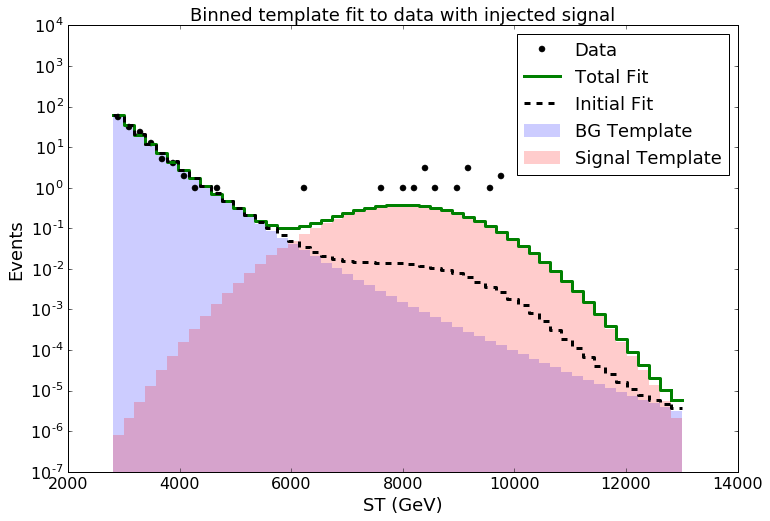

In [117]:
fig, ax = plt.subplots()
bin_centers = bin_centres = (be_bg[:-1] + be_bg[1:])/2.
#bin_widths = be[1:]-be[:-1]
ax.plot(bin_centers, bc, 'ko', label='Data')
fill_between_steps(ax, be_bg, bg_frac_bc, -2, alpha=0.2, step_where='pre',linewidth=1, color='b', label='BG Template')
fill_between_steps(ax, be_bg, sig_frac_bc, -2, alpha=0.2, step_where='pre',linewidth=1, color='r', label='Signal Template')
ax.step(be_bg[:-1], result.best_fit, linewidth=3, linestyle='-', color='g', where='post', label='Total Fit')
ax.step(be_bg[-2:], result.best_fit[-2:], linewidth=3, linestyle='-', color='g', where='pre')
ax.step(be_bg[:-1], result.init_fit, linewidth=3, linestyle='--', color='k', where='post', label='Initial Fit')
ax.step(be_bg[-2:], result.init_fit[-2:], linewidth=3, linestyle='--', color='k', where='pre')
plt.xlabel('ST (GeV)')
plt.ylabel('Events')
plt.title('Binned template fit to data with injected signal')
plt.legend()

plt.yscale('log', nonposy='clip')
ax.set_ylim(1e-7,1e4)


In [118]:
result.params['A'].value*result.params['ntot'].value

4.8520636228134011